This is the google colab notebook for training/retraining the PointNet model for different pointgroups. There are 31 different models corresponding to the different pointgroups (pointgroup 1 does not have a model), each model is a binary predictor to indicate the presence of the pointgroup symmetries. 




Please enter which pointgroup model is to be trained

Choose from:
  1bar;
  2;
  m;
  2m;
  222;
  mm2;
  mmm;
  4;
  4bar;
  4m;
  422;
  4mm;
  4bar2m;
  4mmm;
  3;
  3bar;
  32;
  3m;
  3barm;
  6;
  6bar;
  6m;
  622;
  6mm;
  6barm2;
  6mmm;
  23;
  2m3bar;
  432;
  4bar3m;
  4m3bar2m;


In [ ]:
PG = '32'

# Preamble

For running in Google Colab, determine the path to the folder in google drive, or clone the repository.

In [ ]:
#@title Paths and Filenames

# # Optional mount and work with google drive
# from google.colab import drive
# drive.mount('/content/gdrive')

# path = '/content/gdrive/MyDrive/Colab Notebooks/StructurePrediction/'
# weights_path = path + 'Weights/'
# data_path = path + 'DataSets/'


# For use with Google Colab without mounting drive
%cd /content
!rm -rf crystal_structure_prediction
!git clone --single-branch --depth=1 https://github.com/adrianwalsh1990/crystal_structure_prediction.git
%cd crystal_structure_prediction
!unzip '/content/crystal_structure_prediction/DataSets/materialsdatabase.json.zip' -d '/content/crystal_structure_prediction/DataSets/'

weights_path = '/content/crystal_structure_prediction/Weights/'
data_path = '/content/crystal_structure_prediction/DataSets/'
filename = 'materialsdatabase.json'
fname = data_path + filename 

model_name = weights_path + 'Pointgroup-' + PG


In [ ]:
#@title Import libraries and  mount drive
!pip install trimesh
import pandas as pd
import trimesh
import numpy as np
import tensorflow as tf
import os
import glob
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.activations import relu
from tensorflow.python.keras.backend import categorical_crossentropy
from tensorflow.python.keras.metrics import accuracy
from tensorflow.python.keras.metrics import AUC 
from tensorflow.python.keras.metrics import FalsePositives
from tensorflow.python.keras.metrics import FalseNegatives
from tensorflow.python.keras.metrics import TruePositives
from tensorflow.python.keras.metrics import TrueNegatives
from tensorflow.python.keras.optimizer_v1 import adam
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt



# Prepare the data

The atomic positions from all samples are read from the data file to a numpy array. These points are padded by repeating the first atomic site, until all inputs are of the same length.

In [ ]:
#@title Prepare the sites datapoints from the json file.
# Read in atomic positions
file = pd.read_json(fname)
x = file['structure.sites.xyz'].to_numpy()

# Max number of atomic sites
num_sites = file['nsites'].to_numpy()
NUM_POINTS = np.amax(num_sites)


# Pad the atomic positions until all have the same number of sites
x_padded = np.array([xi + [xi[0]] * (NUM_POINTS - len(xi)) for xi in x])

The labels are all the samples are set using the space groups. The choice of PG above determines which point group is being trained. Therefore all space group labels will be converted to a 1 or 0 depending on the presence of the point group symmetry, given by the dictionary.

In [ ]:
#@title Prepare the output, i.e. using the spacegroup number to indicate the presence of particular pointgroups

y = file['spacegroup.number'].to_numpy()

# Space group to corresponding Point Groups
PointGroups = {
    '1bar':[2] + list(range(10,16)) + list(range(47, 75)) + list(range(83,89)) +
           list(range(123,143)) + [147,148] + list(range(162,168)) + [175,176] +
           list(range(191,195)) + list(range(200,207)) + list(range(221,231)),
    '2':[3,4,5,10,11,12,13,14,15] + list(range(16,143)) + list(range(149, 156)) 
        + list(range(162,174)) + list(range(175,231)),
    'm':list(range(6,16)) + list(range(25, 75)) + list(range(83,89)) + 
        list(range(99,143)) + list(range(156,168)) + list(range(174,177)) + 
        list(range(183,195)) +  list(range(200,207)) + list(range(215,231)),
    '2m':list(range(10,16)) + list(range(47, 75)) + list(range(83,89)) + 
         list(range(123,143)) + list(range(162,168)) + [175, 176] + 
         list(range(191,195)) + list(range(200,207)) + list(range(221,231)),
    '222':list(range(16,25)) + list(range(47, 75)) + list(range(89,99)) + 
          list(range(111,143)) + list(range(177,183)) + list(range(191,231)),
    'mm2':list(range(25,75)) + list(range(99, 143)) + list(range(183,195)) + 
          list(range(200,207)) + list(range(215,231)),
    'mmm':list(range(47,75)) + list(range(123, 143)) + list(range(191,195)) + 
          list(range(200,207)) + list(range(221,231)),
    '4':list(range(75,81)) + list(range(83, 111)) + list(range(123,143)) + 
        list(range(207,215)) + list(range(221,231)),
    '4bar':list(range(81,89)) + list(range(111, 143)) + list(range(215,231)),
    '4m':list(range(83,89)) + list(range(123,143)) + list(range(221,231)),
    '422':list(range(89,99)) + list(range(123,143)) + list(range(207,215)) + 
          list(range(200,207)) + list(range(221,231)),
    '4mm':list(range(99,111)) + list(range(123,143)) + list(range(221,231)),
    '4bar2m':list(range(111,143)) + list(range(215,231)),
    '4mmm':list(range(123,143)) + list(range(221,231)),
    '3':list(range(143,231)),
    '3bar':[147,148] + list(range(162,168)) + list(range(175,177)) + 
           list(range(191,195)) + list(range(200,207)) + list(range(221,231)),
    '32':list(range(149,156)) + list(range(162,168)) + list(range(177,183)) + 
         list(range(187,195)) + list(range(207,215)) + list(range(221,231)),
    '3m':list(range(156,168)) + list(range(183,195)) + list(range(215,231)),
    '3barm':list(range(162,168)) + list(range(191,195)),
    '6':list(range(168,174)) + list(range(175,187)) + list(range(191,195)),
    '6bar':list(range(174,177)) + list(range(187,195)),
    '6m':[175,176] + list(range(191,195)),
    '622':list(range(177,183)) + list(range(191,195)),
    '6mm':list(range(183,187)) +  list(range(191,195)),
    '6barm2':list(range(187,195)),
    '6mmm':list(range(191,195)),
    '23':list(range(195,231)),
    '2m3bar':list(range(200,207)) + list(range(221,231)),
    '432':list(range(207,215)) + list(range(221,231)),
    '4bar3m':list(range(215,221)) + list(range(221,231)),
    '4m3bar2m':list(range(221,231))    
}

# Covert space groups into 1/0 presence of point group
for i in list(set(y)):
    if i in PointGroups.get(PG,-1):
      y[y == i] = 1
    else:
      y[y==i] = 0

Prepare the train/test datasets, which are coverted to tensors. The augmentation function is designed to jitter and shuffle the train dataset.



In [ ]:
# @title Create the train/test datasets

train_points, test_points, train_labels, test_labels = train_test_split(x_padded, y, test_size=0.1)

def augment(points, label):
    # jitter points
    points += tf.random.uniform(points.shape, -0.005, 0.005, dtype=tf.float64)
    # shuffle points
    points = tf.random.shuffle(points)
    return points, label


BATCH_SIZE = 512

train_points = tf.convert_to_tensor(train_points)
test_points = tf.convert_to_tensor(test_points)


train_dataset = tf.data.Dataset.from_tensor_slices((train_points, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_points, test_labels))

train_dataset = train_dataset.shuffle(len(train_points)).map(augment).batch(BATCH_SIZE)
test_dataset = test_dataset.shuffle(len(test_points)).batch(BATCH_SIZE)

<function matplotlib.pyplot.show>

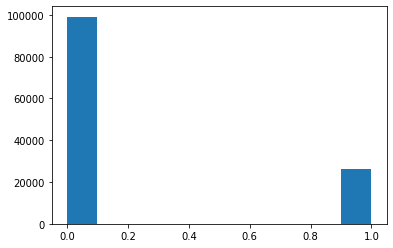

In [ ]:
# @title Show Histogram of Training Points
plt.hist(train_labels)
plt.show

# Create and Train the model

In [ ]:
# @title Create the model

# Example modified from the Keras Code Example 
# https://keras.io/examples/vision/pointnet/

METRIC = "TruePositives","TrueNegatives","FalsePositives",
         "FalseNegatives"


def conv_bn(x, filters):
    x = layers.Conv1D(filters, kernel_size=1, padding="valid")(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)

def dense_bn(x, filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)

class OrthogonalRegularizer(keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = tf.eye(num_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))

def tnet(inputs, num_features):
    # Initalise bias as the indentity matrix
    bias = keras.initializers.Constant(np.eye(num_features).flatten())
    reg = OrthogonalRegularizer(num_features)

    x = conv_bn(inputs, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = dense_bn(x, 128)
    x = layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=reg,
    )(x)
    feat_T = layers.Reshape((num_features, num_features))(x)
    # Apply affine transformation to input features
    return layers.Dot(axes=(2, 1))([inputs, feat_T])

inputs = keras.Input(shape=(NUM_POINTS, 3))

x = tnet(inputs, 3)
x = conv_bn(x, 32)
x = conv_bn(x, 32)
x = tnet(x, 32)
x = conv_bn(x, 32)
x = conv_bn(x, 64)
x = conv_bn(x, 512)

x = layers.GlobalMaxPooling1D()(x)


x = dense_bn(x, 256)
x = layers.Dropout(0.3)(x)
x = dense_bn(x, 128)
x = layers.Dropout(0.3)(x)


outputs = layers.Dense(1, activation=tf.nn.sigmoid)(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")

model.compile(
    loss="binary_crossentropy",
    optimizer='adam',
    metrics=[METRIC],
)

Note if OOM errors occur here, consider reducing the BATCH_SIZE above, as this depends on the colab resource allocation available.

In [ ]:
# @title Train new model
model.fit(train_dataset, epochs=100, validation_data=test_dataset)

model.save_weights(model_name)

results = model.evaluate(test_points, test_labels)


The weights for the model have been saved, and can be loaded in the CrystalPrediction.ipynb to predict the presence of the point group symmetry